In [735]:
import numpy as np
import numba
import sys
import re
import os

In [742]:
coord_pattern = re.compile('[0-2],[0-2]')
if pattern.match('1,3'):
    print(True)

In [885]:
class TicTacToe(object):
    """
    A class of functions that can be used to generate next moves from a node and test for a win. 
    """
    def __init__(self):
        self.board_width = 3
        self.player_ids = [-1,1]
        
    def get_next_player(self, player):
        '''
        gets the Id of the next player
        '''
        return player * -1
        
    def get_winner(self, board):
        '''
        If a board has a winner, the index of the winner is returned. 
        Returns -1 if loss, 1 if win, 0 if draw and nan if game is not finished
        '''
        win_arrays =[np.array([player] * self.board_width) for player in self.player_ids]
        
        for i, winner in enumerate([1, -1]):
            win_array = win_arrays[i]
            for i in range(self.board_width):
                # check rows
                if np.array_equal(board[i], win_array):
                    return winner
                #check columns
                elif np.array_equal(board[:,i], win_array):
                    return winner
                # check leading diagonal
                elif np.array_equal(np.diagonal(board), win_array):
                    return winner
                # check non-leading diagonal
                elif np.array_equal(np.diagonal(np.flipud(board)), win_array):
                    return winner
        # return nan if no wins losses or draws
        for i in np.nditer(board):
            if i == 0:
                return np.nan
        # must be a draw so return 0
        return 0
    
    def get_moves(self, board, player):
        '''
        Return a list of all possible moves from a given board
        '''
        moves = []
        for x in range(self.board_width):
            for y in range(self.board_width):
                if board[x][y] == 0:
                    copy = board.copy()
                    copy[x][y] = player
                    moves.append(copy)
        return moves
    
    def display_board(self, board):
        '''
        Print the current board state
        '''
        string = str(board)
        string = string.replace('0', ' ')
        string = string.replace('-1', ' O')
        string = string.replace('1', 'X')
        print(string)
        
    def expand(self, node):
        '''
        Generates a new node for each possible move from the current node
        '''
        moves = self.get_moves(node.board, node.player)
        
        for move in moves:
            next_player = self.get_next_player(node.player)
            
            node.children.append(
                Node(move, 
                     next_player,
                     parent=node))
            
        node.visits += 1  
        node.expanded = True
        return node
    
    def play_out(self, node, print_path=False):
        '''
        Play out a given board state - selecting moves at random until the game ends
        '''
        if np.isnan(node.end_state):
            node.winner = self.get_winner(node.board)
            node.end_state = not np.isnan(node.winner)
        
        if node.end_state:
            return node.winner
        else:
            player = node.player
            board = node.board
            moves = [np.nan]

            while np.isnan(self.get_winner(board)) and len(moves) > 0:
                moves = self.get_moves(board, player)
                board_index = np.random.randint(len(moves))
                board = moves[board_index]
                player = self.get_next_player(player)

                if print_path:
                    for move in moves:
                        self.display_board(move)
                    print()
            return self.get_winner(board)     
    
    def start_state(self):
        '''
        Returns the inital board state (an empty 3 * 3 grid)
        '''
        return np.zeros((3*3))

In [886]:
class Node(object):
    '''
    A node in the tree of possible moves. Can generate children 
    and calculate whether the current board has been won by a player.
    
    As a convention, Machine goes first and has ID 1, human has id -1
    '''
    def __init__(self, board, player, parent=None):
        self.board = board
        self.player = player
        self.children = []
        self.winner = np.nan
        self.end_state = np.nan
        self.wins = 0
        self.losses = 0
        self.visits = 0
        self.UCB = np.inf
        self.parent = parent
        self.expanded = False
        self.hash = str(self.board)
        
    def get_score(self):
        '''
        Returns the fraction of wins compared to the number of simulated games
        '''
        denominator = self.wins + self.losses
        # If no games have been simulated, guess that the score is 0.5
        if denominator == 0:
               return 0.5
        else:
            return self.wins / denominator

In [944]:
class MonteCarloTreeSearch(object):
    def __init__(self, game):
        self.game = game
        self.iterations = 100
        self.hash_table = {}
    
    def calculate_UCB(self, node):
        '''
        Calculate the UCB score for a node
        '''
        if not node.expanded:
            return np.inf
        
        if node.visits == 0:
            return np.inf
        else:
            ln_N = np.log(node.parent.visits)
        
        return node.get_score() + (2 * np.sqrt(ln_N/node.visits))

    def index_max(self, values):
        '''
        Return the index of the largest value in an array
        '''
        return max(range(len(values)), key=values.__getitem__)
    
    def get_highest_UCB(self, node):
        '''
        Return the child with the highest UCB from a node
        '''
        UCBs = []
        for child in node.children:
            child.UCB = self.calculate_UCB(child)
            UCBs.append(child.UCB)
        max_index = self.index_max(UCBs)
        
        return node.children[max_index]
    
    def backpropogate(self, path, winner):
        '''
        Backpropogate the result of the simulation along the path taken to the leaf node
        '''
        for node in path:
            if node.player != winner:
                node.losses += 1
            else:
                node.wins += 1
        
    def simulate(self, root_node):
        '''
        Traverse the tree, following the pasth of largest UCB until a leaf not is reached.
        Simulate a random game from that leaf node and backpropagate the result back up the tree
        '''
        node = root_node
        path = [node] # record the nodes that are traversed

        #follow the nodes with the highest UCB until a node that is un-expanded is reached
        while node.expanded and not node.end_state:
            node.visits += 1
            node = self.get_highest_UCB(node)
            path.append(node)

        self.game.expand(node)
        winner = self.game.play_out(node)
        self.backpropogate(path, winner)
    
    def get_next_move(self, board, player=1):
        '''
        Explore the possiblity tree to generate the next move for the machine
        '''
        
        # If a node is already in the tree, select it, otherwise create a new node
        if str(board) in self.hash_table:
            root_node = self.hash_table[str(board)]
        else:
            root_node = Node(board, player)
            self.hash_table[root_node.hash] = root_node
        
        # Follow the path of highest UCB to a leaf, expand it, and simulate
        # a random game from that point
        for iterations in range(self.iterations):
            self.simulate(root_node)
            
        # Look through the scores for each possible next move and select 
        # the one with highest score
        scores = [child.get_score() for child in root_node.children]
        best_index = self.index_max(scores)
        
        return root_node.children[best_index].board, root_node

In [961]:
game = TicTacToe()
searcher = MonteCarloTreeSearch(game)
searcher.iterations = 10000
empty_board = np.zeros((3,3), dtype=np.int8)

In [962]:
move, node = searcher.get_next_move(empty_board)
move

array([[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]], dtype=int8)

In [963]:
for child in node.children:
    print(child.board, child.get_score())

[[1 0 0]
 [0 0 0]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x129DCB10>>
[[0 1 0]
 [0 0 0]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x129DC390>>
[[0 0 1]
 [0 0 0]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x129DC4D0>>
[[0 0 0]
 [1 0 0]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x129DCBB0>>
[[0 0 0]
 [0 1 0]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x1402DAD0>>
[[0 0 0]
 [0 0 1]
 [0 0 0]] <bound method Node.get_score of <__main__.Node object at 0x1402D550>>
[[0 0 0]
 [0 0 0]
 [1 0 0]] <bound method Node.get_score of <__main__.Node object at 0x1402D390>>
[[0 0 0]
 [0 0 0]
 [0 1 0]] <bound method Node.get_score of <__main__.Node object at 0x1402D4F0>>
[[0 0 0]
 [0 0 0]
 [0 0 1]] <bound method Node.get_score of <__main__.Node object at 0x1402D0B0>>


In [980]:
class MiniMax(object):
    def __init__(self):
        empty_board = np.zeros((3,3), dtype=np.int8)
        self.player = 1
        self.root = Node(empty_board, self.player)
        self.hash_table = {str(self.root.board): self.root}
        self.game = TicTacToe()
        
    def traverse(self, node):
        winner = self.game.get_winner(node.board)
        if not np.isnan(winner):
            return winner
        else:
            self.game.expand(node)
            total = 0
            for child in node.children:
                if self.traverse(child) == node.player:
                    node.wins += 1
                    total += 1
                node.visits += 1
        self.hash_table[str(node.board)] = node
        return total
        
m = MiniMax()
m.traverse(m.root)

0

In [1133]:
def play_out(node, print_path=False):
    '''
    Play out a given board state - selecting moves at random until the game ends
    '''
    self = TicTacToe()
    if np.isnan(node.end_state):
        node.winner = get_winner(node.board)
        node.end_state = not np.isnan(node.winner)

    if node.end_state:
        return node.winner
    else:
        player = node.player
        board = node.board
        moves = [np.nan]

        while np.isnan(get_winner(board)) and len(moves) > 0:
            moves = self.get_moves(board, player)
            board_index = np.random.randint(len(moves))
            board = moves[board_index]
            player = self.get_next_player(player)
            
            if print_path:
                self.display_board(board)
                print()
        return get_winner(board)

board = np.array([[ 1, -1, -1], [ 1,  1,  0], [ 0,  0,  0]], dtype=np.int8)
TicTacToe().display_board(board)
print('---------------')
node = Node(board, -1)
scores = {-1: 0, 0: 0, 1: 0}
for i in range(1000):
    result = play_out(node, print_path=False)
    scores[result] += 1    
scores

[[ X  O  O]
 [ X  X   ]
 [        ]]
---------------


{-1: 85, 0: 0, 1: 915}

In [2]:
import numpy as np
import numba
import sys
import re
import os
from games import TicTacToe
from node import Node
import argparse

class InputError(Exception):
    pass

class MonteCarloTreeSearch(object):
    def __init__(self, game):
        self.game = game
        self.iterations = 1000
        self.hash_table = {}

    def calculate_UCB(self, node):
        '''
        Calculate the UCB score for a node
        '''
        if not node.expanded:
            return np.inf

        if node.visits == 0:
            return np.inf
        else:
            ln_N = np.log(node.parent.visits)

        return node.get_score() + (np.sqrt((2 * ln_N)/node.visits))

    def index_max(self, values):
        '''
        Return the index of the largest value in an array. Select at random if
        draw.
        '''
        max_val = max(values)
        max_indices = [ind for ind, val in enumerate(values) if val == max_val]
        return np.random.choice(max_indices)

    def get_highest_UCB(self, node):
        '''
        Return the child with the highest UCB from a node
        '''
        UCBs = []
        for child in node.children:
            child.UCB = self.calculate_UCB(child)
            UCBs.append(child.UCB)
        max_index = self.index_max(UCBs)

        return node.children[max_index]

    def backpropogate(self, path, winner):
        '''
        Backpropogate the result of the simulation along the path taken to the leaf node
        '''
        for node in path:
            if node.player != winner:
                node.wins += winner
            node.visits += 1

    def simulate(self, root_node):
        '''
        Traverse the tree, following the pasth of largest UCB until a leaf not is reached.
        Simulate a random game from that leaf node and backpropagate the result back up the tree
        '''
        node = root_node
        path = [node] # record the nodes that are traversed

        #follow the nodes with the highest UCB until a node that is un-expanded is reached
        while node.expanded and not node.end_state:
            node = self.get_highest_UCB(node)
            path.append(node)

        self.game.expand(node)
        winner = self.game.play_out(node, print_board=True)
        self.backpropogate(path, winner)

    def get_next_move(self, board, player=1):
        '''
        Explore the possiblity tree to generate the next move for the machine
        '''

        # If a node is already in the tree, select it, otherwise create a new node
        if str(board) in self.hash_table:
            root_node = self.hash_table[str(board)]
        else:
            root_node = Node(board, player)
            self.hash_table[root_node.hash] = root_node

        # Follow the path of highest UCB to a leaf, expand it, and simulate
        # a random game from that point
        for iterations in range(self.iterations):
            self.simulate(root_node)

        # Look through the scores for each possible next move and select
        # the one with highest score
        scores = [child.get_score() for child in root_node.children]
        best_index = self.index_max(scores)

        return root_node.children[best_index].board, root_node

In [3]:
MCTS = MonteCarloTreeSearch(TicTacToe())
board = np.array([[ 1, -1, -1], [ 0,  1,  0], [ 0,  0,  0]], dtype=np.int8)
_, node = MCTS.get_next_move(board)

for child in node.children:
    print(child.board)
    print(child.wins, child.visits)
    print(child.get_score())
    print()

[[ 1 -1 -1]
 [ 1  1  0]
 [ 0  0  0]]
283 289
0.9792387543252595

[[ 1 -1 -1]
 [ 0  1  1]
 [ 0  0  0]]
140 156
0.8974358974358975

[[ 1 -1 -1]
 [ 0  1  0]
 [ 1  0  0]]
106 123
0.8617886178861789

[[ 1 -1 -1]
 [ 0  1  0]
 [ 0  1  0]]
60 78
0.7692307692307693

[[ 1 -1 -1]
 [ 0  1  0]
 [ 0  0  1]]
353 353
1.0



In [29]:
a = np.array([0,0,0,0,1,-1])
for index, val in np.flip(a):
    if val == 0:
        break


array([False, False,  True,  True,  True,  True])

In [60]:
a = np.array([0,0,0,0,2,3,4])
for i, val in enumerate(a[::-1]):
    if val == 0:
        break
i

3

In [16]:
from games import TicTacToe, Connect4
import numpy as np
import numba

self = Connect4()
self.board_size = np.array(self.board_size)
self.player_ids = np.array(self.player_ids)




%timeit get_winner(self, )

The slowest run took 4.51 times longer than the fastest. This could mean that an intermediate result is being cached.
40.9 µs ± 30.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [153]:
def display_board(board):
    '''
    Nicely display the current board
    '''
    # print x axis labels
    sys.stdout.write('  ')
    for y in range(board.shape[0]):
        sys.stdout.write('{} '.format(y))
    print()

    # print the actual board
    for x, row in enumerate(board):
        sys.stdout.write(str(x))
        for val in row:
            if val == 1:
                sys.stdout.write('|w')
            elif val == 2:
                sys.stdout.write('|W') # king white
            elif val == -1:
                sys.stdout.write('|b')
            elif val == -2:
                sys.stdout.write('|B') # king black
            else:
                sys.stdout.write('| ')
        print('|')

In [213]:
board = np.array([ [0, -1, 0, -1, 0, -1, 0, -1],
                   [-1, 0, -1, 0, -1, 0, -1, 0],
                   [0, -1, 0, -1, 0, -1, 0, -1],
                   [0, 0, 0, 0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0, 0, 0, 0],
                   [1, 0, 0, 0, 1, 0, 1, 0],
                   [0, 1, 0, 1, 0, 1, 0, 1],
                   [1, 0, 1, 0, 1, 0, 1, 0]], dtype=np.int8)
display_board(board)

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | | | | | | |
5|w| | | |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |


In [1]:
from games import Draughts

game = Draughts()

board = game.start_state()
game.display_board(board)

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | | | | | | |
5|w| |w| |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |


In [2]:
for move in game.get_moves(board, 1):
    game.display_board(move)
    print()

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| |w| | | | | | |
5| | |w| |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| |w| | | | | | |
5|w| | | |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | |w| | | | |
5|w| | | |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | |w| | | | |
5|w| |w| | | |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | | | |w| | |
5|w| |w| | | |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| |b|
3| | | | | | | | |
4| | | | | |w| | |
5|w| |w| |w| | | |
6| |w| 

In [144]:
b = np.zeros((8,8), dtype=object)
for x in range(8):
    for y in range(8):
        b[x][y] = str((x,y))
print(b)

[['(0, 0)' '(0, 1)' '(0, 2)' '(0, 3)' '(0, 4)' '(0, 5)' '(0, 6)' '(0, 7)']
 ['(1, 0)' '(1, 1)' '(1, 2)' '(1, 3)' '(1, 4)' '(1, 5)' '(1, 6)' '(1, 7)']
 ['(2, 0)' '(2, 1)' '(2, 2)' '(2, 3)' '(2, 4)' '(2, 5)' '(2, 6)' '(2, 7)']
 ['(3, 0)' '(3, 1)' '(3, 2)' '(3, 3)' '(3, 4)' '(3, 5)' '(3, 6)' '(3, 7)']
 ['(4, 0)' '(4, 1)' '(4, 2)' '(4, 3)' '(4, 4)' '(4, 5)' '(4, 6)' '(4, 7)']
 ['(5, 0)' '(5, 1)' '(5, 2)' '(5, 3)' '(5, 4)' '(5, 5)' '(5, 6)' '(5, 7)']
 ['(6, 0)' '(6, 1)' '(6, 2)' '(6, 3)' '(6, 4)' '(6, 5)' '(6, 6)' '(6, 7)']
 ['(7, 0)' '(7, 1)' '(7, 2)' '(7, 3)' '(7, 4)' '(7, 5)' '(7, 6)' '(7, 7)']]


In [6]:
setattr(board, 'moves_since_capture', 0)
board

AttributeError: 'numpy.ndarray' object has no attribute 'moves_since_capture'

In [35]:
from games import Draughts
'''
  0 1 2 3 4 5 6 7
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| | |
3| | |w| | | |b| |
4| | | | | | | | |
5|w| | | |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |
'''
board = np.array(
            [[0, -1, 0, -1, 0, -1, 0, -1], 
             [-1, 0, -1, 0, -1, 0, -1, 0],
             [0, -1, 0, -1, 0, -1, 0, 0], 
             [0, 0, 1, 0, 0, 0, -1, 0],
             [0, 0, 0, 0, 0, 0, 0, 0], 
             [1, 0, 0, 0, 1, 0, 1, 0],
             [0, 1, 0, 1, 0, 1, 0, 1], 
             [1, 0, 1, 0, 1, 0, 1, 0]],
            dtype=np.int8)
d = Draughts()
d.display_board(board)

  0 1 2 3 4 5 6 7 
0| |b| |b| |b| |b|
1|b| |b| |b| |b| |
2| |b| |b| |b| | |
3| | |w| | | |b| |
4| | | | | | | | |
5|w| | | |w| |w| |
6| |w| |w| |w| |w|
7|w| |w| |w| |w| |


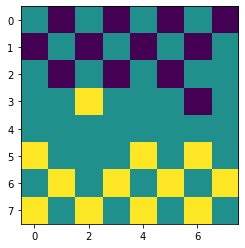

In [36]:
from matplotlib import pyplot as plt
plt.imshow(board)
plt.show()

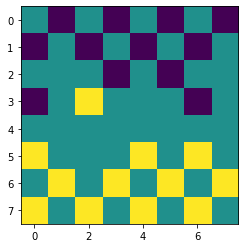

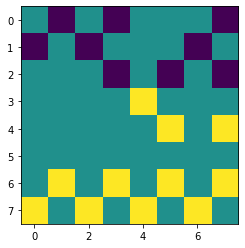

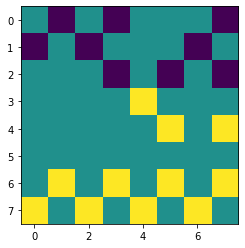

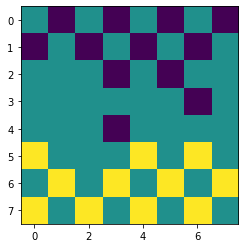

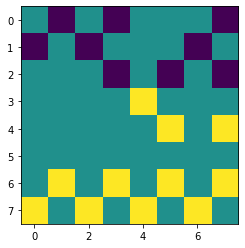

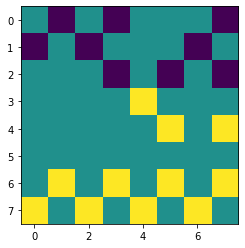

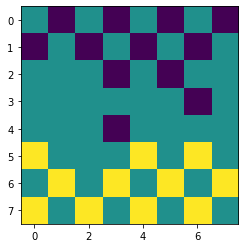

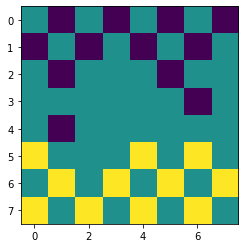

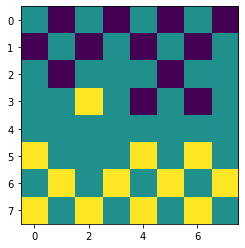

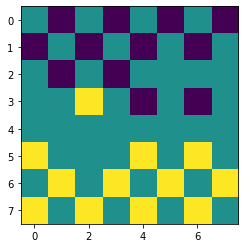

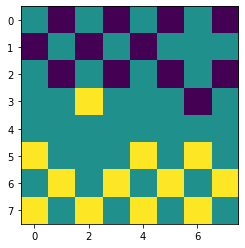

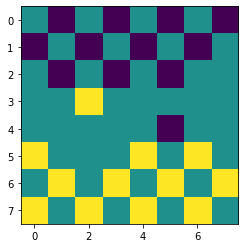

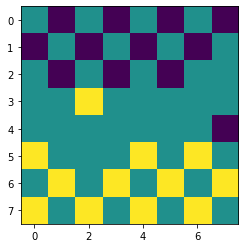

In [38]:
for move in d.get_moves(board, -1):
    plt.imshow(move)
    plt.show()

In [45]:
def get_moves(board, player, width, height):
    '''
    Return a list of all possible moves from a given board
    '''
    moves = []
    for x in range(width):
        copy = board.copy()
        for y in range(height):
            if board[x][height - y -1] == 0:
                copy[x][height - y -1] = player
                moves.append(copy)
    return moves

def get_moves_np(board, player):
    '''
    Return a list of all possible moves from a given board
    '''
    moves = []
    for x, col in enumerate(board.T):
        if 0 in col:
            for y, val in enumerate(col[::-1]):
                if val == 0:
                    y = len(col) - y - 1
                    break
            copy = board.copy()
            copy[y][x] = player
            moves.append(copy)
    return moves

@numba.jit()
def get_moves_c(board, player, height, width):
    '''
    Return a list of all possible moves from a given board
    '''
    moves = []
    for x in range(width):
        copy = board.copy()
        for y in range(height):
            if board[height - y - 1][x] == 0:
                copy[height - y - 1][x] = player
                moves.append(copy)
                break
    return moves

get_moves_c(np.zeros((6,7), dtype=np.int8), 1, 6,7) 

[array([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0]], dtype=int8), array([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0]], dtype=int8), array([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0]], dtype=int8), array([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0]], dtype=int8), array([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0]], dtype=int8), arra

In [94]:
board = np.array([[ 1, -1, -1], [ 0,  1,  0], [ 0,  0,  1]], dtype=np.int8)
node = Node(board, -1)

MCTS.simulate(node)